In [1]:
import cv2
import numpy as np
import mediapipe as mp
from collections import deque
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mphands = mp.solutions.hands
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
VisionRunningMode = mp.tasks.vision.RunningMode
import tensorflow as tf
import keras


# STEP 2: Create an GestureRecognizer object.
base_options = python.BaseOptions(model_asset_path='./models/gesture_recognizer.task')
options = vision.GestureRecognizerOptions(base_options=base_options, running_mode=VisionRunningMode.IMAGE)
recognizer = vision.GestureRecognizer.create_from_options(options)

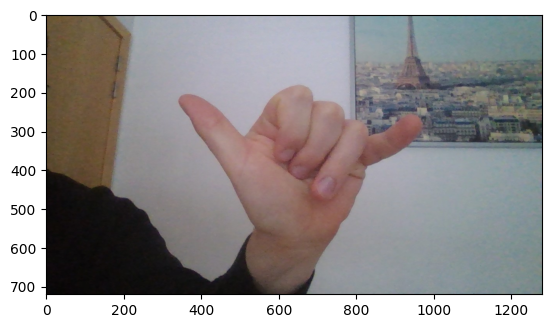

In [2]:
import matplotlib.pyplot as plt
testimage = cv2.imread('./data/surfing/WIN_20240621_17_52_30_Pro.jpg')
testimage = cv2.cvtColor(cv2.flip(testimage, 1), cv2.COLOR_BGR2RGB)
plt.imshow(testimage, )

In [3]:
mp_image = mp.Image.create_from_file('./data/surfing/WIN_20240621_17_52_30_Pro.jpg')


In [4]:
mp.Image(image_format=mp.ImageFormat.SRGB, data=testimage)

In [5]:
mp_image

In [6]:
handprocessor = mphands.Hands()

In [7]:
solution = handprocessor.process(testimage)

c:\Users\simon\anaconda3\envs\cv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [8]:
import json
def preprocess_json(json_str):
    # Parse the JSON string
    history_points = json.loads(json_str)
    
    # Flatten the list of landmarks into a single list
    point_history = []
    for _, values in history_points.items():
        flattened_points = []
        for point in values:
            flattened_points.extend([point['X'], point['Y']])
        point_history.append(flattened_points)
    return point_history

def flatten_point_history(point_history):
    # Parse the JSON string    
    # Flatten the list of landmarks into a single list
    point_history = []
    for values in point_history:
        flattened_points = []
        for point in values:
            flattened_points.extend([point.x, point.y])
        point_history.append(flattened_points)
    return point_history



In [19]:
def calc_bounding_rect(image, landmarks):
    image_width, image_height = image.shape[1], image.shape[0]

    landmark_array = np.empty((0, 2), int)

    for _, landmark in enumerate(landmarks.landmark):
        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)

        landmark_point = [np.array((landmark_x, landmark_y))]

        landmark_array = np.append(landmark_array, landmark_point, axis=0)

    x, y, w, h = cv2.boundingRect(landmark_array)

    return [x, y, x + w, y + h]

def draw_info_text(image, brect, recognition_result):
    cv2.rectangle(image, (brect[0], brect[1]), (brect[2], brect[1] - 22),
                 (0, 0, 0), -1)

    if len(recognition_result.gestures)>0:
        info_text = recognition_result.gestures[0][0].category_name
        cv2.putText(image, info_text, (brect[0] + 5, brect[1] - 4),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)
    return image

def draw_bounding_rect(use_brect, image, brect):
    if use_brect:
        cv2.rectangle(image, (brect[0], brect[1]), (brect[2], brect[3]),
                     (0, 0, 0), 1)
    return image

def draw_info(image, text):
    cv2.putText(image, "Motion:" + str(text), (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
               1.0, (0, 0, 0), 4, cv2.LINE_AA)
    return image


In [10]:
calc_bounding_rect(testimage)

TypeError: calc_bounding_rect() missing 1 required positional argument: 'landmarks'

In [11]:
from collections import deque

In [12]:
history_length = 50
point_history = deque(maxlen=history_length)

In [13]:
import csv
import json
def logging_csv(number, mode, point_history_list):
    if mode == 0:
        pass
    if mode == 1 and (0 <= number <= 9):
        print("point history written")
        csv_path = 'data/point_history.csv'

        keypoints = {}
        # Iterate over each index and data point in point_history
        for index in range(len(point_history_list)):
            # Initialize an empty list to hold the points for the current index
            keypoints[index] = []

            # Iterate over each data point in the current index
            for data_point in point_history_list[index]:
                # Append the dictionary with X, Y, Z coordinates to the list
                keypoints[index].append({
                    'X': data_point.x,
                    'Y': data_point.y,
                    'Z': data_point.z,
                })
        json_data = json.dumps(keypoints, indent=2)

        with open(csv_path, 'a', newline="") as f:
            writer = csv.writer(f)
            writer.writerow([number, json_data])
    return

def select_mode(key, mode):
    number = -1
    if 48 <= key <= 57:  # 0 ~ 9
        number = key - 48
    if key == 110:  # n
        mode = 0
    if key == 107:  # k
        mode = 1
    if key == 104:  # h
        mode = 2
    return number, mode


In [14]:
wave_recognizer = keras.saving.load_model("./models/waving.keras")


In [29]:
def flatten_point_history(point_history):
    # Parse the JSON string    
    # Flatten the list of landmarks into a single list
    point_history_list = []
    for values in point_history:
        flattened_points = []
        for point in values:
            flattened_points.extend([point.x, point.y])
        point_history_list.append(flattened_points)
    return point_history_list



In [27]:
    point_history = []
    for values in point_history:
        flattened_points = []
        for point in values:
            flattened_points.extend([point.x, point.y])
        point_history.append(flattened_points)


In [54]:
wave_recognizer.predict(np.array(flatten_point_history(point_history)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


array([[0.00764257, 0.99766   ]], dtype=float32)

In [15]:
import time

In [41]:
prediction = wave_recognizer.predict(np.array(flattened_input).reshape(1,50,42))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [45]:
cap = cv2.VideoCapture(0)
hands = mphands.Hands()
mode = 0
buffer_time = 0.5  # 500ms
last_update_time = time.time()
prediction_buffer = []
history_length = 50
point_history = deque(maxlen=history_length)
wave_recognizer = keras.saving.load_model("./models/waving.keras")
while True:
    key = cv2.waitKey(10)
    if key == 27:  # ESC
        break
    number, mode = select_mode(key, mode)
    data, image = cap.read()
    image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)
    results = hands.process(image)
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    recognition_result = recognizer.recognize(mp_image)
    brect = None
    if results.multi_hand_landmarks:
        brect = calc_bounding_rect(image, results.multi_hand_landmarks[0])
        point_history.append(list(results.multi_hand_landmarks[0].landmark))
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                image,
                hand_landmarks, mphands.HAND_CONNECTIONS
            )
        logging_csv(number, mode, point_history)
        flattened_input = flatten_point_history(point_history)
        if len(flattened_input) == 50:
            prediction = wave_recognizer.predict(np.array(flattened_input).reshape(1,50,42))
            prediction_buffer.append(prediction)
            print(prediction_buffer)
            # Check if 500ms have passed
    current_time = time.time()
    if current_time - last_update_time >= buffer_time:
        if prediction_buffer:
            mean_prediction = np.mean(prediction_buffer, axis=0)
            print(mean_prediction)
            # Reset the buffer and timer
            prediction_buffer = []
        last_update_time = current_time
    if mean_prediction[0][0]>0.9:
        image = draw_info(image, text = "waving")

    else: image = draw_info(image, text = "")
    #if recognition_result:
    #    top_gesture = recognition_result.gestures[0][0]
    #    hand_landmarks = recognition_result.hand_landmarks
    if brect:
        image = draw_bounding_rect(True, image, brect=brect)
        if recognition_result:
            image = draw_info_text(image=image, brect=brect, recognition_result=recognition_result)
    cv2.imshow('Handtracker', image)
# After the loop release the cap object 
cap.release() 
# Destroy all the windows 
cv2.destroyAllWindows() 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
[array([[0.04670832]], dtype=float32)]
[[0.04670832]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[array([[0.05265516]], dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[array([[0.05265516]], dtype=float32), array([[0.05230993]], dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[array([[0.05265516]], dtype=float32), array([[0.05230993]], dtype=float32), array([[0.05347659]], dtype=float32)]
[[0.05281389]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[array([[0.0538468]], dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[array([[0.0538468]], dtype=float32), array([[0.05428232]], dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[array([[0.0538468]], dtype=float32), array([[0.05428232]], dtype=float32), array([[0.05319784]], dtype=float32)]
[[0.05377565]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[array([[0.05359398]], dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[array([[0.05359398]], dtype=float32), array([[0.05329722]], dtype=float32)

In [67]:
mean_prediction[0][0]<0.2

0.007804745

In [117]:
jsontest = pd.read_csv("./data/point_history.csv", header=None)